## Máster en Big Data y Data Science

### Metodologías de gestión y diseño de proyectos de big data

#### AP2 - Modelado y evaluación

---

En esta libreta se realiza la experimentación para generación del modelo de predicción objetivo del proyecto y la evaluación del mismo.
La versión del dataset a utilizar es la obtenida a partir de las operaciones de transformación.

---

En esta versión de la libreta se va a incorporar el registro de los detalles de la experimentacion con la libreria MLFow

In [1]:
# Se importan las librerías necesarias y se suprimen las advertencias
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=UserWarning)

Se agrega la libreria mlflow y se configura

In [3]:
import mlflow
import mlflow.sklearn
from datetime import datetime

#Configuracion mlflow
mlflow.set_tracking_uri('file:./mlruns')
mlflow.set_experiment('Proyecto 13MBID-ABR2526- Experimentacion Original')

<Experiment: artifact_location='file:///c:/Users/herne/Documents/VIU/13MBID/Actividad1/13MBID-ABRIL2526/notebooks/mlruns/267290865350095295', creation_time=1762453306429, experiment_id='267290865350095295', last_update_time=1762453306429, lifecycle_stage='active', name='Proyecto 13MBID-ABR2526- Experimentacion Original', tags={}>

In [4]:
# Lectura de los datos
df = pd.read_csv('../data/processed/bank-processed.csv')
df.head(5)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,1,0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,1,0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,1,0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,1,0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,1,0,0


In [5]:
# Se divide el dataset en variables predictoras y variable objetivo
X = df.drop('y_yes', axis=1)
y = df['y_yes']

In [6]:
# Se genera el conjunto de entrenamiento y prueba con estratificación
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [7]:
# Se separan las columnas numéricas
numerical_columns=X_train.select_dtypes(exclude='object').columns
display(numerical_columns)

categorical_columns=X_train.select_dtypes(include='object').columns
display(categorical_columns)

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'housing_yes', 'loan_yes', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_married', 'marital_single', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

Index([], dtype='object')

In [8]:
# Se verifica la distribución de la variable objetivo en el conjunto de entrenamiento
y_train.value_counts()

y_yes
0    27179
1     3406
Name: count, dtype: int64

In [9]:
# Se crea un pipeline para preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler  

# Pipeline para valores numéricos
num_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

# Pipeline para valores categóricos
cat_pipeline = Pipeline(steps=[
    ('OneHotEncoder', OneHotEncoder(drop='first',sparse_output=False))
])

# Se configuran los preprocesadores
preprocessor_full = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_columns),
    ('cat_pipeline', cat_pipeline, categorical_columns)
]).set_output(transform='pandas')

In [10]:
preprocessor_train_valid = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_columns),
    ('cat_pipeline', cat_pipeline, categorical_columns)
]).set_output(transform='pandas')

In [11]:
# Se ajusta y transforma el conjunto de entrenamiento y prueba
x_train_prep = preprocessor_full.fit_transform(X_train)
x_test_prep = preprocessor_full.transform(X_test)

In [12]:
# Se aplica submuestreo a los datos preprocesados
from sklearn.utils import resample

# Combinar los datos preprocesados con las etiquetas
train_data = x_train_prep.copy()
train_data['target'] = y_train.reset_index(drop=True)

# Separar por clase
class_0 = train_data[train_data['target'] == 0]
class_1 = train_data[train_data['target'] == 1]

# Encontrar la clase minoritaria
min_count = min(len(class_0), len(class_1))

# Submuestreo balanceado - tomar una muestra igual al tamaño de la clase minoritaria
class_0_balanced = resample(class_0, n_samples=min_count, random_state=42)
class_1_balanced = resample(class_1, n_samples=min_count, random_state=42)

# Combinar las clases balanceadas
balanced_data = pd.concat([class_0_balanced, class_1_balanced])

# Separar características y objetivo
x_train_resampled = balanced_data.drop('target', axis=1)
y_train_resampled = balanced_data['target']

print(f"Tamaño original: {len(x_train_prep)}")
print(f"Tamaño balanceado: {len(x_train_resampled)}")
print(f"Distribución balanceada: {y_train_resampled.value_counts()}")

Tamaño original: 30585
Tamaño balanceado: 5438
Distribución balanceada: target
0.0    2719
1.0    2719
Name: count, dtype: int64


Esteapartado se vaa cmbair

In [62]:
from sklearn.model_selection import cross_val_score


# Se genera una función para realizar validación cruzada
def cross_val(model):
    scores = cross_val_score(model,x_train_resampled , y_train_resampled, cv=5, scoring='f1')
    print('cross validation f1 scores',scores*100)
    print('cross validation f1 mean',scores.mean()*100)
    print('cross validation f1 std',scores.std())
    print('-'*50)
    scores = cross_val_score(model,x_train_resampled , y_train_resampled, cv=5, scoring='recall')
    print('cross validation recall scores',scores*100)
    print('cross validation recall mean',scores.mean()*100)
    print('cross validation recall std',scores.std())

---
El cambio consiste en que la funcion directamente registre los detalles de la experimentacion en mlflow

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from mlflow.models import infer_signature

def cross_val_mlflow(model, model_name, params=None):
    with mlflow.start_run(run_name=model_name):
            f1_scores = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring='f1')
            f1_mean = f1_scores.mean()
            f1_std = f1_scores.std()

            recall_scores = cross_val_score(model, x_train_resampled, y_train_resampled, cv= 5, scoring='recall')
            recall_mean = recall_scores.mean()
            recall_std = recall_scores.std()

            precision_scores = cross_val_score(model, x_train_resampled, y_train_resampled, cv= 5, scoring='precision')
            precision_mean = precision_scores.mean()
            precision_std = precision_scores.std()

            accuracy_scores = cross_val_score(model, x_train_resampled, y_train_resampled, cv= 5, scoring='accuracy')
            accuracy_mean = accuracy_scores.mean()
            accuracy_std = accuracy_scores.std()

            #Entramos al modelo
            model.fit(x_train_resampled, y_train_resampled)

            # Predecimos
            y_pred = model.predict(x_test_prep)

            #Obtenemos model signature
            signature = infer_signature(x_train_resampled, y_pred)
            test_f1 = f1_score(y_test, y_pred)
            test_recall = recall_score(y_test, y_pred)
            test_precision = precision_score(y_test, y_pred)
            test_accuracy = accuracy_score(y_test, y_pred)

            # Registramos parametros
            if params:
                mlflow.log_params(params)
            else:
                 mlflow.log_params(model.get_params())

            mlflow.log_params({
                 "train_samples":len(x_train_resampled),
                 "test_samples":len(x_test_prep),
                 "balancing_method": 'undersampling',
                 "cv_folds": 5
            })

            mlflow.log_metrics({
                 'cv_f1_mean': f1_mean,
                 'cv_f1_std': f1_std,
                 'cv_recall_mean': recall_mean,
                 'cv_recall_std': recall_std,
                 'cv_precision_mean': precision_mean,
                 'cv_precision_std': precision_std,
                 'cv_accuracy_mean': accuracy_mean,
                 'cv_accuracy_std': accuracy_std,
                 'test_f1': test_f1,
                 'test_recall': test_recall,
                 'test_precision': test_precision,
                 'test_acuracy': test_accuracy,
            })

            mlflow.sklearn.log_model(model,
                                     artifact_path='model',
                                     signature=signature)
            
            print(f"Model {model_name} registrado en MLFlow con ID de ejecucion: {mlflow.active_run().info.run_id}")

            return model, {
                 'cv_f1_mean': f1_mean,
                 'cv_recall_mean': recall_mean,                 
                 'cv_precision_mean': precision_mean,                 
                 'cv_accuracy_mean': accuracy_mean,
                 'test_f1': test_f1,
                 'test_recall': test_recall,
                 'test_precision': test_precision,
                 'test_acuracy': test_accuracy,
            }

---
Se cambian estas celdas por una solo que hace todas las llamadas

In [14]:
# Se aplica un modelo de regresión logística
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1,penalty='l2',solver='liblinear',random_state=1,max_iter=100,tol=0.000000001)

# cross validation scores
cross_val(lr)

cross validation f1 scores [53.07621671 51.51793928 54.3876567  52.88197621 50.41246563]
cross validation f1 mean 52.45525090743166
cross validation f1 std 0.01367728770824499
--------------------------------------------------
cross validation recall scores [53.125      51.47058824 51.83823529 53.2228361  50.55147059]
cross validation recall mean 52.04162604268227
cross validation recall std 0.010155758537285817


In [15]:
# LinearSVC
from sklearn.svm import LinearSVC
svc = LinearSVC(max_iter=10000,tol=0.001)

# cross validation scores
cross_val(svc)

cross validation f1 scores [53.11355311 51.9266055  54.10628019 52.96803653 50.41246563]
cross validation f1 mean 52.50538819378433
cross validation f1 std 0.012539599287462733
--------------------------------------------------
cross validation recall scores [53.30882353 52.02205882 51.47058824 53.40699816 50.55147059]
cross validation recall mean 52.151987866969996
cross validation recall std 0.010914359491373081


In [16]:
# knclassifier
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=7)

# cross validation scores
cross_val(knc)

cross validation f1 scores [57.03703704 57.35027223 55.30776093 58.84444444 56.42857143]
cross validation f1 mean 56.99361721402016
cross validation f1 std 0.011589683065219536
--------------------------------------------------
cross validation recall scores [56.61764706 58.08823529 56.98529412 60.95764273 58.08823529]
cross validation recall mean 58.14741089806088
cross validation recall std 0.015228328367793535


In [17]:
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()

# cross validation scores
cross_val(tree)

cross validation f1 scores [71.42857143 68.53146853 68.98305085 70.00864304 69.91304348]
cross validation f1 mean 69.77295546562188
cross validation f1 std 0.009981459427712567
--------------------------------------------------
cross validation recall scores [74.08088235 71.875      75.18382353 74.4014733  73.89705882]
cross validation recall mean 73.88764760047665
cross validation recall std 0.010983867705894336


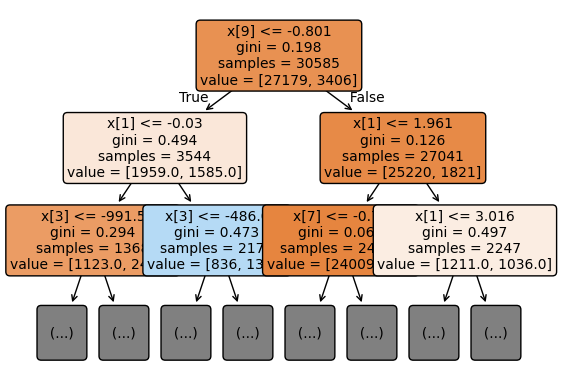

In [18]:
# decision tree plot
from sklearn.tree import plot_tree
tree.fit(x_train_prep, y_train)
plot_tree(tree, filled=True, rounded=True,max_depth=2,fontsize=10)
plt.show()

In [19]:
# Se obtiene la matriz de confusión para el modelo
from sklearn.metrics import confusion_matrix

y_pred = tree.predict(x_test_prep)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[6341  455]
 [ 384  467]]


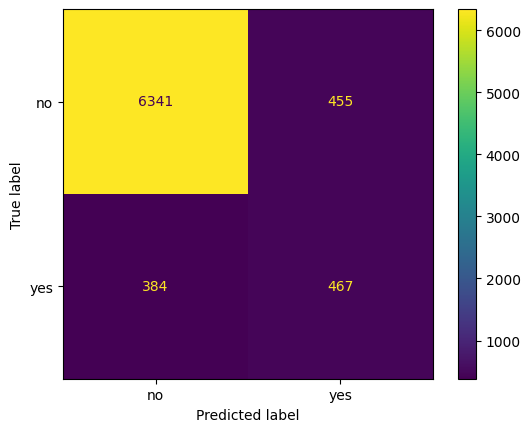

In [20]:
# Se visualiza la matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot()

---
Esta es la nueva celda que hace la invocacion del proceso con MLFlow

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

results = {}
lr = LogisticRegression(C=1,penalty='l2',solver='liblinear',random_state=1,max_iter=100,tol=0.000000001)
model_lr, metrics_lr = cross_val_mlflow(lr, 'Logistic Regression')
results['Logistic Regression'] = metrics_lr

svc = LinearSVC(max_iter=10000,tol=0.001)
model_svc, metrics_svc = cross_val_mlflow(svc, 'Linear SVC')
results['Linear SVC'] = metrics_svc

knc = KNeighborsClassifier(n_neighbors=7)
model_knc, metrics_knc = cross_val_mlflow(svc, 'K-Nearest Neighbours')
results['K-Nearest Neighbours'] = metrics_knc


tree=DecisionTreeClassifier()
model_tree, metrics_tree = cross_val_mlflow(svc, 'Decision Tree Classifier')
results['Decision Tree Classifier'] = metrics_tree


2025/11/06 21:37:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Logistic Regression registrado en MLFlow con ID de ejecucion: 24877fcef0ef4aa88d6d28ed015eb959


2025/11/06 21:37:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Linear SVC registrado en MLFlow con ID de ejecucion: 3ee01c10b9dc4478a50b93d6d76258a3


2025/11/06 21:37:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model K-Nearest Neighbours registrado en MLFlow con ID de ejecucion: 5d59efa2411f46f9a00d6fc0fca72f90


2025/11/06 21:37:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Decision Tree Classifier registrado en MLFlow con ID de ejecucion: ec2517ff1b0b4e528cfe22d913c5bf79


A continuación se realiza una comparación de los modelos para seleccionar el que  va a ser utilizado posteriormente:

In [20]:
df_comparacion = pd.DataFrame(results).T
df_comparacion = df_comparacion.round(4)
df_comparacion = df_comparacion.sort_values(by = 'test_f1', ascending = False)

print(df_comparacion)

print(f"El mejor modelo basado en F1 en el conjunto de prueba es: {df_comparacion.index[0]}")
print(f"Valor de F1 en test: {df_comparacion.iloc[0]['test_f1']}")
print(f"Valor de recall en test: {df_comparacion.iloc[0]['test_recall']}")

                          cv_f1_mean  cv_recall_mean  cv_precision_mean  \
Logistic Regression           0.5246          0.5204             0.5292   
Linear SVC                    0.5251          0.5215             0.5292   
K-Nearest Neighbours          0.5251          0.5215             0.5292   
Decision Tree Classifier      0.5251          0.5215             0.5292   

                          cv_accuracy_mean  test_f1  test_recall  \
Logistic Regression                 0.5279   0.1103       0.2667   
Linear SVC                          0.5279   0.1092       0.2597   
K-Nearest Neighbours                0.5279   0.1092       0.2597   
Decision Tree Classifier            0.5279   0.1092       0.2597   

                          test_precision  test_acuracy  
Logistic Regression               0.0695        0.5211  
Linear SVC                        0.0691        0.5283  
K-Nearest Neighbours              0.0691        0.5283  
Decision Tree Classifier          0.0691        0.5283 

#### Predicción con datos nuevos (sin clasificar)

In [21]:
df_nuevos = pd.read_csv('../data/raw/bank-additional-new.csv')
df_nuevos.head(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,contacted_before
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN


In [22]:
# Diagnosticar el problema con los nuevos datos
print("Información del conjunto de datos nuevos:")
print(f"Forma: {df_nuevos.shape}")
print("\nTipos de datos:")
print(df_nuevos.dtypes)
print("\nValores nulos:")
print(df_nuevos.isnull().sum())
print("\nColumnas categóricas en nuevos datos:")
print(df_nuevos.select_dtypes(include='object').columns.tolist())
print("\nColumnas numéricas en nuevos datos:")
print(df_nuevos.select_dtypes(exclude='object').columns.tolist())

Información del conjunto de datos nuevos:
Forma: (9, 20)

Tipos de datos:
age                   int64
job                  object
marital              object
education            object
housing              object
loan                 object
contact              object
month                object
day_of_week          object
duration              int64
campaign              int64
previous              int64
poutcome             object
emp_var_rate        float64
cons_price_idx      float64
cons_conf_idx       float64
euribor3m           float64
nr_employed         float64
y                    object
contacted_before    float64
dtype: object

Valores nulos:
age                 0
job                 0
marital             0
education           0
housing             0
loan                0
contact             0
month               0
day_of_week         0
duration            0
campaign            0
previous            0
poutcome            0
emp_var_rate        0
cons_price_idx      0
cons_c

In [23]:
# Comparar con los datos de entrenamiento originales
print("Comparación de columnas:")
print(f"Columnas en datos originales: {list(X.columns)}")
print(f"Columnas en datos nuevos: {list(df_nuevos.columns)}")

print("\nColumnas que están en nuevos pero no en originales:")
new_cols = set(df_nuevos.columns) - set(X.columns)
print(new_cols)

print("\nColumnas que están en originales pero no en nuevos:")
missing_cols = set(X.columns) - set(df_nuevos.columns)
print(missing_cols)

Comparación de columnas:
Columnas en datos originales: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'housing_yes', 'loan_yes', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success']
Columnas en datos nuevos: ['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous', 'p

In [24]:
import pandas as pd
import numpy as np

df = df_nuevos

df.head(5)
# Se ajustan los nombres de las columnas para que no contengan puntos
df.columns = df.columns.str.replace(".", "_")

# Transformar los valores 'unknown' en NaN
df.replace('unknown', np.nan, inplace=True)

# Se hace un filtro para eliminar las filas duplicadas
df = df.drop_duplicates()

# Transformaciones extra: estandarizamos las variables categoricas
df = pd.get_dummies(df, columns=[
"housing", "loan", "job", "marital", "education", "contact", "month", 
"day_of_week", "poutcome", "y"
], drop_first=True)

# Transformaciones extra: Convertimos ls variables boolenas en numericas
df = df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

In [25]:
df_nuevos.head(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,contacted_before
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN


In [ ]:
# Se hace la predicción con los nuevos datos
# Primero, eliminar la columna objetivo si existe y preparar las características
X_new = df_nuevos.drop('y_', axis=1) if 'y' in df_nuevos.columns else df_nuevos.copy()

# Asegurar que las columnas estén en el mismo orden que en el entrenamiento
X_new = X_new[X.columns]

# Manejar la columna contacted_before para que coincida con el formato de entrenamiento
# En entrenamiento: 'no', 'yes' (string)
# En nuevos datos: NaN -> necesita convertirse a 'no' (asumiendo que NaN significa no contactado)
X_new['contacted_before'] = X_new['contacted_before'].fillna('no')

# Convertir cualquier valor numérico a string si es necesario
if X_new['contacted_before'].dtype in ['float64', 'int64']:
    X_new['contacted_before'] = X_new['contacted_before'].map({0.0: 'no', 1.0: 'yes'}).fillna('no')

# Asegurar que contacted_before sea de tipo object como en entrenamiento
X_new['contacted_before'] = X_new['contacted_before'].astype('object')

# Transformar los nuevos datos usando el mismo preprocesador y predecir
try:
    x_new_prep = preprocessor_full.transform(X_new)
    
    y_new_pred = tree.predict(x_new_prep)
    print(f"\nPredicciones: {y_new_pred}")
    
    predictions_df = pd.DataFrame({
        'Cliente': range(1, len(y_new_pred) + 1),
        'Predicción_Numérica': y_new_pred,
        'Suscribirá': ['No' if pred == 0 else 'Sí' for pred in y_new_pred]
    })
    print("\nResultados detallados:")
    print(predictions_df.to_string(index=False))
    
    # Resumen de predicciones
    pred_counts = pd.Series(y_new_pred).value_counts()
    print("\nResumen de predicciones:")
    for pred_val, count in pred_counts.items():
        label = 'No realizará un depósito' if pred_val == 0 else 'Sí realizará un depósito'
        print(f"  {label}: {count} clientes ({count/len(y_new_pred)*100:.1f}%)")
    
except Exception as e:
    print(f"Error durante el preprocesamiento o predicción: {e}")
    print("Información adicional para depuración:")
    print(f"Tipos de datos en X_new:\n{X_new.dtypes}")

KeyError: "['y_'] not found in axis"